In [1]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt

# to ensure changes in aux_files are reflected dynamically
import importlib
import aux_files
importlib.reload(aux_files)
from aux_files import Linear, BatchNorm1d, Tanh, Embedding, Sequential, FlattenConsecutive

In [2]:
words = open('names.txt').read().splitlines()

In [3]:
allchars = sorted(set(''.join(words)))

stoi = {s:i+1 for i,s in enumerate(allchars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [4]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
words_shuffled = words[:]  # shallow copy -- to preserve across runs
random.shuffle(words_shuffled)
n1 = int(0.8*len(words_shuffled))
n2 = int(0.9*len(words_shuffled))

Xtr,  Ytr  = build_dataset(words_shuffled[:n1])     # 80%
Xdev, Ydev = build_dataset(words_shuffled[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words_shuffled[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [5]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [9]:
g = torch.Generator().manual_seed(3445676536)

n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
batch_size = 32

C = torch.randn((vocab_size, n_embd))

# changed model
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [10]:
# Optimization loop - same as earlier

max_iters = 200000
lossi = []

for iter in range(max_iters):

    # define batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = nn.functional.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None # flush gradients
    loss.backward()

    # update - SGD
    lr = 0.1 if iter < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    #print
    lossi.append(loss.item())
    if iter % 10000 == 0:
        print(f'iter: {iter}/{max_iters}: loss = {loss.item()}')
    
    # if iter == 100:
    #     break


iter: 0/200000: loss = 3.5229883193969727
iter: 10000/200000: loss = 1.6484172344207764
iter: 20000/200000: loss = 1.9477514028549194
iter: 30000/200000: loss = 1.9256640672683716
iter: 40000/200000: loss = 1.9162728786468506
iter: 50000/200000: loss = 1.856515884399414
iter: 60000/200000: loss = 2.0389578342437744
iter: 70000/200000: loss = 2.3045454025268555
iter: 80000/200000: loss = 1.5391825437545776
iter: 90000/200000: loss = 1.636509895324707
iter: 100000/200000: loss = 2.1913836002349854
iter: 110000/200000: loss = 1.791128396987915
iter: 120000/200000: loss = 1.9796326160430908
iter: 130000/200000: loss = 1.8877861499786377
iter: 140000/200000: loss = 1.810704231262207
iter: 150000/200000: loss = 1.693022608757019
iter: 160000/200000: loss = 1.8980060815811157
iter: 170000/200000: loss = 1.501137614250183
iter: 180000/200000: loss = 1.6878021955490112
iter: 190000/200000: loss = 1.5790033340454102


In [11]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


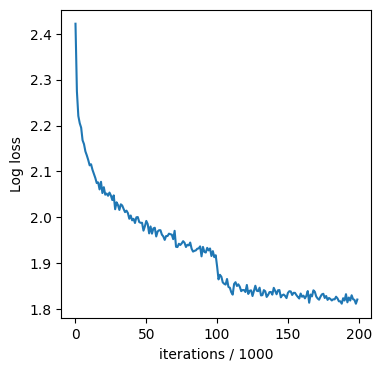

In [12]:
lossi = torch.tensor(lossi)
lossi = lossi.view(-1,1000) # 200,1000

plt.figure(figsize=(4,4))
plt.plot(lossi.mean(dim = 1)) # 200 points only across all iterations
plt.ylabel('Log loss')
plt.xlabel('iterations / 1000')
plt.show()

In [13]:
# to ensure batch norm parameters are not trainined on eval data!
for layer in model.layers:
    layer.training = False

In [14]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = torch.nn.functional.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.783880352973938
val 1.9924705028533936


In [23]:
(lossi.mean(dim = 1))[-10:] # latest training losses

tensor([1.8187, 1.8326, 1.8148, 1.8253, 1.8187, 1.8302, 1.8217, 1.8202, 1.8118,
        1.8209])

In [24]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = torch.nn.functional.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ryesiah.
denazz.
wystin.
noalani.
cariannah.
mylian.
ase.
joseline.
torry.
bailee.
edibigo.
zepper.
mathil.
brisee.
paubash.
gileanovarias.
bohder.
deciah.
kareni.
camar.


### Performance log: 

- original (3 char context + 1 hidden layer - 200 neurons; 12k parameters): train 2.06, val: 2.10
- context: 3 -> 8 (22k params): train: 1.92, val: 2.02
- flat -> tree structure, n_hidden = 68 (22k params): train: 1.94, val: 2.02
- tree structure, n_hidden = 128 (76k params): train: 1.78 val: 1.992

## On Convolution:

The [Wavenet paper](https://arxiv.org/pdf/1609.03499) implements convolutions __strictly__ to improve compute efficiency. The tree-like hierarchical architecture is same as what we have implemented. 

Intuition for convolution: 

In [26]:
# consider a single name:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [27]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [28]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

So basically we call our model 8 times to forward a point through it and convolution presents a 'sliding' mechanism which performs these operations __without explicit model call for each__ datapoint. 

So convolution plays role of a efficient 'equivalent of the for loop'.

# Conclusion and open areas:

- We obv have many hard coded hyperparameters (n_hidden, batch_size, embd_dim etc) over which we are manually trying permutations. This is less than ideal and we would normally have grids of hyperparameters to search over for the optimum set.

- Play around with initialization, different optimization algos

- How to deploy this into production? <br>
Usually you tinker with shapes, dimensions etc in a jupyter nb and then copy it finally to a single .py file to execute into production. I have to look this up. 
